In [71]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas.tseries.offsets import DateOffset
from scipy.optimize import minimize
%matplotlib inline

In [5]:
aapl = pd.read_csv('AAPL_CLOSE', index_col='Date', parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE', index_col='Date', parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE', index_col='Date', parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE', index_col='Date', parse_dates=True)

In [12]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis=1)
stocks.columns = ['AAPL Close', 'CISCO Close', 'IBM Close', 'AMZN Close']

In [13]:
stocks.head()

,AAPL Close,CISCO Close,IBM Close,AMZN Close
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [15]:
stocks.pct_change(1).mean()

AAPL Close     0.000750
CISCO Close    0.000599
IBM Close      0.000081
AMZN Close     0.001328
dtype: float64

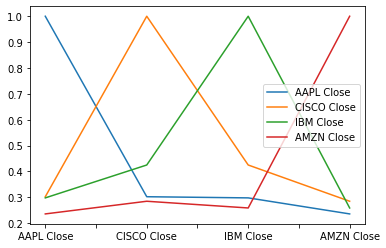

In [16]:
stocks.pct_change(1).corr().plot()

In [17]:
stocks.pct_change(1).head()

,AAPL Close,CISCO Close,IBM Close,AMZN Close
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


In [18]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,AAPL Close,CISCO Close,IBM Close,AMZN Close
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2714cd90>,
      dtype=object)

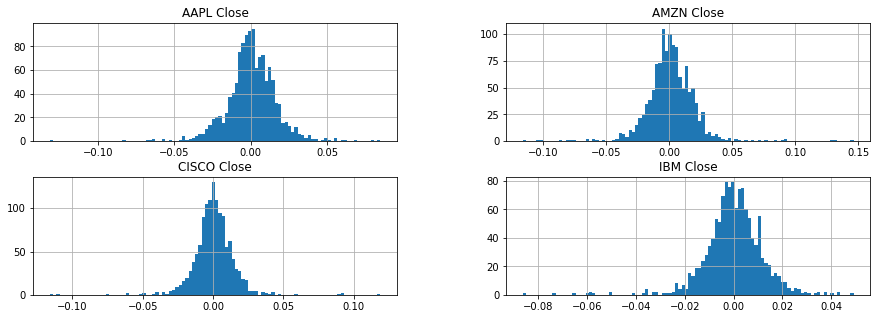

In [19]:
log_ret.hist(bins=100, figsize=(15,5))

In [20]:
log_ret.mean()

AAPL Close     0.000614
CISCO Close    0.000497
IBM Close      0.000011
AMZN Close     0.001139
dtype: float64

In [21]:
log_ret.cov()

,AAPL Close,CISCO Close,IBM Close,AMZN Close
AAPL Close,0.000271,0.000071,0.000057,0.000075
CISCO Close,0.000071,0.000204,0.000072,0.000079
IBM Close,0.000057,0.000072,0.000140,0.000059
AMZN Close,0.000075,0.000079,0.000059,0.000375


In [22]:
log_ret.describe()

,AAPL Close,CISCO Close,IBM Close,AMZN Close
count,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.000614,0.000497,0.000011,0.001139
std,0.016466,0.014279,0.011819,0.019362
min,-0.131875,-0.116091,-0.086419,-0.116503
25%,-0.007358,-0.006240,-0.005873,-0.008534
50%,0.000455,0.000213,0.000049,0.000563
75%,0.009724,0.007634,0.006477,0.011407
max,0.085022,0.118862,0.049130,0.146225


In [59]:
log_ret.cov() * 252
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # ExpectedReturn
    ret_arr[ind] = np.sum(log_ret.mean() * weights) * 252


    # Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))


    # Sharper Ratio
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]


In [61]:
sharpe_arr.max()

1.0303260551271067

In [62]:
sharpe_arr.argmax()

1420

In [63]:
all_weights[1420, :]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [67]:
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

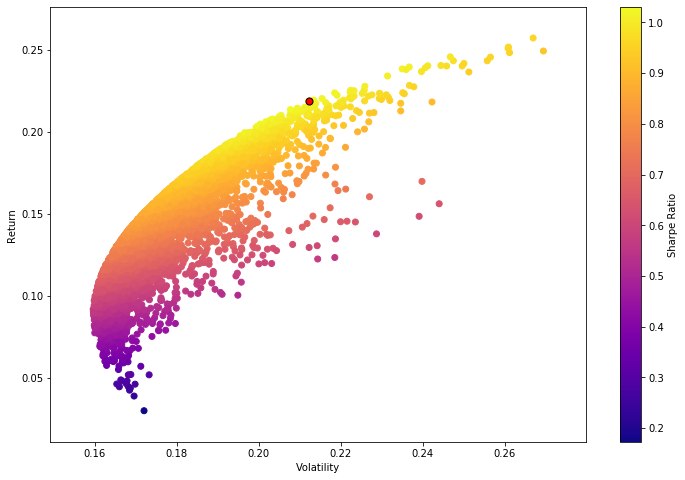

In [69]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')


plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [70]:
def get_ret_vol_sr(weigths):
    weights = np.array(weigths)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

In [72]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]* -1

In [73]:
def check_sum(weights):
    # retunr ) if the sum of the weighs is 1
    return np.sum(weights) - 1

In [78]:
cons = ({'type':'eq', 'fun':check_sum})

In [75]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [76]:
init_guess = [.25,.25,.25,.25]

In [80]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -1.0307168703346403
     jac: array([ 5.64604998e-05,  4.18424606e-05,  3.39921728e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289779e-01, 2.04189821e-01, 3.56634752e-17, 5.29520400e-01])

In [81]:
opt_results.x

array([2.66289779e-01, 2.04189821e-01, 3.56634752e-17, 5.29520400e-01])

In [82]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

In [83]:
frontier_y = np.linspace(0, .3, 100)

In [89]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [91]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
           {'type':'eq', 'fun':lambda w: get_ret_vol_sr(w)[0] -possible_return})
    result =minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    
    frontier_volatility.append(result['fun'])

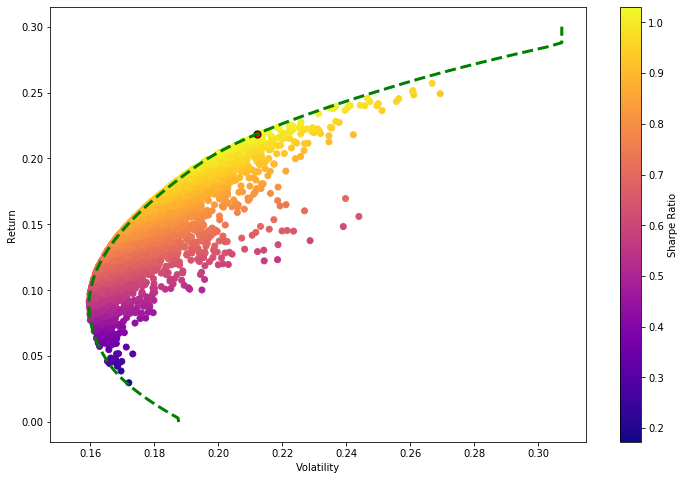

In [92]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')